In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
f = lambda x: 1.0 / (1.0 + x**2)

In [35]:
def composite_simpsons_rule(func, a, b, N):

    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    
    # f(x_0) + 4 f(x_1) + 2 f(x_2) + 4 f(x_3) + ... + f(x_N)
    s = func(x[0]) + func(x[-1])
    # Sum over odd indices
    s += 4.0 * np.sum(func(x[1:-1:2]))
    # Sum over even indices (except the first/last)
    s += 2.0 * np.sum(func(x[2:-1:2]))
    
    return (h / 3.0) * s

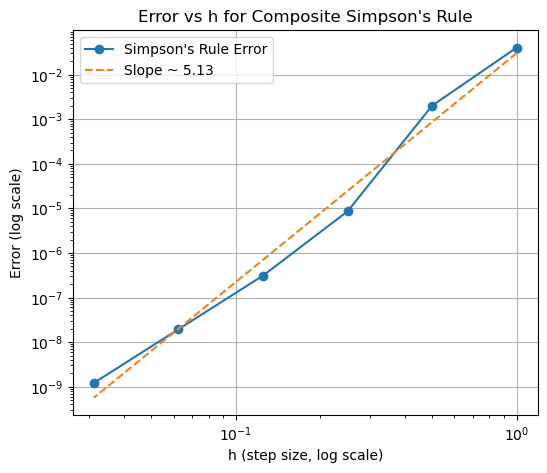

In [36]:
# Integral bounds
a = 0.0
b = 2.0

# Exact value
exact_value = np.arctan(2.0)
Ns = [2, 4, 8, 16, 32, 64]
simpsons_values = []
errors_simpsons = []

for N in Ns:
    approx = composite_simpsons_rule(f, a, b, N)
    err = abs(approx - exact_value)
    simpsons_values.append(approx)
    errors_simpsons.append(err)

# Create a log-log plot of error vs. h for Simpson's Rule
hs = [(b - a)/N for N in Ns]  
plt.figure(figsize=(6,5))
plt.loglog(hs, errors_simpsons, 'o-', label="Simpson's Rule Error")

log_hs = np.log(hs)
log_errs = np.log(errors_simpsons)
slope, intercept = np.polyfit(log_hs, log_errs, 1)
plt.loglog(hs, np.exp(intercept + slope*log_hs), '--', 
            label=f"Slope ~ {slope:.2f}")
plt.xlabel('h (step size, log scale)')
plt.ylabel('Error (log scale)')
plt.title("Error vs h for Composite Simpson's Rule")
plt.legend()
plt.grid(True)
plt.show()


Estimated slope in log-log plot for Simpson's rule error ≈ 5.13
Theoretically, Simpson's rule has degree of precision 4 and the error shoule be $O(h^5)$, which does match the experiment. 

In [37]:
def composite_trapezoid_rule(func, a, b, N):
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    
    # Trapezoid sums: (f(x_0) + 2*f(x_1) + 2*f(x_2) + ... + f(x_N)) * h/2
    s = 0.5*func(x[0]) + 0.5*func(x[-1]) + np.sum(func(x[1:-1]))
    
    return s * h

In [38]:
def romberg_integration(func, a, b, max_k=4):
    """
    T_{k,0} = trapezoidal rule with 2^k subintervals
    T_{k,m} = T_{k,m-1} + (T_{k,m-1} - T_{k-1,m-1}) / (4^m - 1)
    """
    T = [[0.0]*(max_k+1) for _ in range(max_k+1)]
    
    # Fill in the first column: T_{k,0}
    for k in range(max_k+1):
        N = 2**k  
        T[k][0] = composite_trapezoid_rule(func, a, b, N)
        
    for k in range(1, max_k+1):
        for m in range(1, k+1):
            T[k][m] = T[k][m-1] + (T[k][m-1] - T[k-1][m-1]) / (4**m - 1)
    
    return T

In [39]:
max_k = 4
romberg_table = romberg_integration(f, a, b, max_k=max_k)

print("Romberg tableau T_{k,m}:")
for k in range(max_k+1):
    row_str = f"k={k}: "
    for m in range(k+1):
        row_str += f"{romberg_table[k][m]:.9f}  "
    print(row_str)

print("\nComparing diagonal Romberg T_{k,k} vs. Simpson S_{2^k}:")
for k in range(1, max_k+1):
    romberg_diag = romberg_table[k][k]
    N_simpson = 2**k
    simpson_val = composite_simpsons_rule(f, a, b, N_simpson)
    err_romberg = abs(romberg_diag - exact_value)
    err_simpson = abs(simpson_val - exact_value)
    print(f"k={k}, N=2^{k}={N_simpson:2d}:  "
            f"T_{k,k}={romberg_diag:.9f}, err={err_romberg:.9e};  "
            f"S_{N_simpson}={simpson_val:.9f}, err={err_simpson:.9e}")

Romberg tableau T_{k,m}:
k=0: 1.200000000  
k=1: 1.100000000  1.066666667  
k=2: 1.103846154  1.105128205  1.107692308  
k=3: 1.106316632  1.107140124  1.107274252  1.107267616  
k=4: 1.106940463  1.107148406  1.107148958  1.107146969  1.107146496  

Comparing diagonal Romberg T_{k,k} vs. Simpson S_{2^k}:
k=1, N=2^1= 2:  T_(1, 1)=1.066666667, err=4.048205113e-02;  S_2=1.066666667, err=4.048205113e-02
k=2, N=2^2= 4:  T_(2, 2)=1.107692308, err=5.435898982e-04;  S_4=1.105128205, err=2.020512666e-03
k=3, N=2^3= 8:  T_(3, 3)=1.107267616, err=1.188986959e-04;  S_8=1.107140124, err=8.593451671e-06
k=4, N=2^4=16:  T_(4, 4)=1.107146496, err=2.221441885e-06;  S_16=1.107148406, err=3.116429843e-07


Discussion:
- The Romberg method starts with the trapezoid rule (O(h^2)) but rapidly 
  accelerates convergence upon successive Richardson extrapolations.
- For the same number of subintervals N=2^k, the final Romberg estimates typically converge faster than Simpson's rule. 
